<a href="https://colab.research.google.com/drive/1AeeoGxW2clxYLrWhLjdAG9w05aFM9oH-#scrollTo=rCLz8eooU-DU
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Gabriel Vega

* __Rol__: 201904651-9

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import time
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [3]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 64 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [6]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [7]:
#Verificamos no tener valores null o nan
digits.isna().sum().sum() + digits.isnull().sum().sum()


0

Vemos el tipo de datos que tenemos para decidir como proceder

In [8]:
digits.dtypes

c00       int64
c01       int64
c02       int64
c03       int64
c04       int64
          ...  
c60       int64
c61       int64
c62       int64
c63       int64
target    int64
Length: 65, dtype: object

Nos manejamos unicamente con variables numericas, lo que significa un ahorro de trabajo y podemos ir mas directamente a lo importante

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


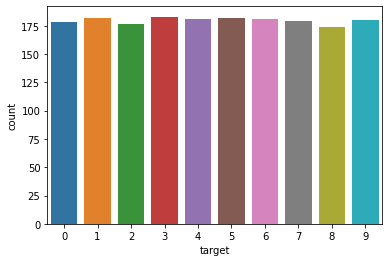

In [9]:
# Split dataset (Parte 1)
Y = digits.target
X = digits.drop('target', axis=1)

# Distribucion
g = sns.countplot(Y)

# Liberamos memoria
#del digits 

En el grafico vemos que los datos se distribuyen de forma similar para los 10 digitos

In [10]:
#Buscamos datos fuera del rango 0-255 (spoiler no hay)
s=0
for c in X.columns:
  aux_bool_sup = X[c] > 255 
  aux_bool_inf = X[c] < 0
  aux_bool = aux_bool_sup | aux_bool_inf
  s += aux_bool.sum()
s

0

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [11]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

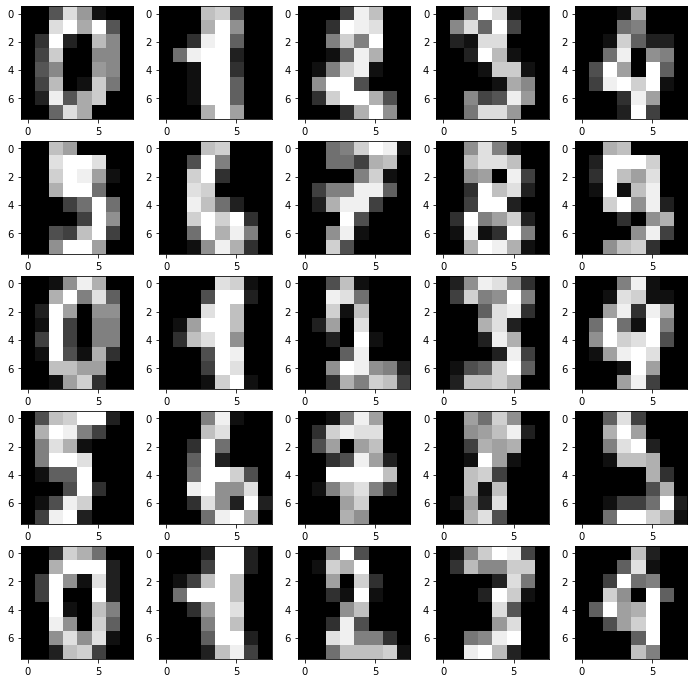

In [37]:
Xarray = X.to_numpy().tolist()
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(25):
  xpos = i//5
  ypos = i%5
  axs[xpos,ypos].imshow(list(digits_dict["images"][i]), cmap = "gray")


### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [13]:
#Normalizamos datos
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

#Split dataset (Parte 2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=27)
print("X_train: " )
print(X_train.shape)
print("\nX_test: " )
print(X_test.shape)

X_train: 
(1347, 64)

X_test: 
(450, 64)


**KNN**

In [14]:
def KNN(x,X_train, Y_train):
  #Añadimos el digito a identificar x al conjunto de datos para construir el modelo
  X_train = X_train.append(x, ignore_index=True)
  xpos = X_train.shape[0]-1
  #Creamos modelo vecinos mas cercanos
  model = NearestNeighbors(n_neighbors = 11)
  fit_model = model.fit(X_train)
  distance, indices = fit_model.kneighbors(X_train)
  #Obtenemos indices para los vecinos (11 vecinos) mas cercanos al desconocido digito x
  indices = list(indices[xpos])
  if(xpos in indices):
    indices.remove(xpos)
  moda, count = stats.mode(np.array(Y_train.iloc[indices]))
  #Retornamos la moda de los digitos correspondientes a los vecinos)(ahora 10 vecinos) mas cercanos
  return list(moda)[0]

In [15]:
Y_predict_KNN = []
for id in range(X_test.shape[0]):
  Y_predict_KNN.append(KNN(X_test.iloc[id], X_train, Y_train))
Y_predict_KNN = np.array(Y_predict_KNN)

**REGRESION** **LOGISTICA**

In [16]:
# Creando el modelo
lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
 
# predecir
Y_predict_LR = lr.predict(X_test)

Comparamos resultados con metrica accuracy y la matriz de confusion


In [17]:
print("Modelo KNN")
print('accuracy:   ',accuracy_score(Y_test, Y_predict_KNN))
print('Matriz de confusion:')
print(confusion_matrix(list(Y_test),Y_predict_KNN))
print("\n \n")
print("Regresion Logistica")
print('accuracy:   ',accuracy_score(Y_test, Y_predict_LR))
print('Matriz de confusion:')
print(confusion_matrix(list(Y_test),Y_predict_LR))

Modelo KNN
accuracy:    0.9755555555555555
Matriz de confusion:
[[39  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 42  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  1  0  0  0  0]
 [ 0  0  0  0 48  0  0  1  0  1]
 [ 0  0  0  0  1 48  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  4  0  0  0  0  0  0 41  0]
 [ 0  0  0  1  0  0  0  0  1 49]]

 

Regresion Logistica
accuracy:    0.9666666666666667
Matriz de confusion:
[[39  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  1  0  0  1  0  0  0]
 [ 0  1 42  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  3  0  0  0  0]
 [ 0  1  0  0 48  0  0  1  0  0]
 [ 0  0  1  0  0 47  1  0  0  0]
 [ 0  1  0  0  0  1 50  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  2  0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  1  0  0  0 50]]


con la metrica accuaracy podemos ver como el modelo de knn es ligeramente mas preciso, aunque ambos tienen una precision cercana a 1 y ademas hay un par de digitos (2 y 8) con una clara tendencia a confusion.
Eso si la forma en que implemente KNN seguramente no es la optima en cuanto a tiempo de ejecucion ya que para cada digito desconocido en X_test hago KNN añadiendolo a X_train, seguramente incluyendo todos los x en X_test de una sola vez a X_train y creando solo 1 vez KNN se podria emparejar el tiempo de ejecucion.
En definitiva me quedaria con el modelo KNN primero por su ligera superioridad en cuanto a acierto y segundo porque el modelo de regresion ya no podria mejorarlo mucho mas en caambio KNN todavia le quedan cosas por optimizar

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


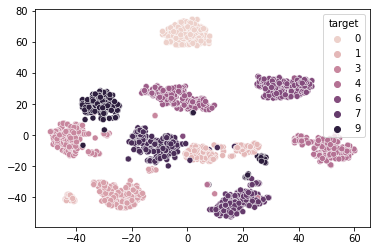

In [18]:
#Primero TSNE
tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue = Y);
X_tsne = pd.DataFrame(X_tsne)

In [19]:
#primero veamos como se redujo el tamaño de los datos
print("Tamaño datos nuevos: " + str(X_tsne.shape))
print("Tamaño datos antiguos: " + str(X.shape))
#Pasamos de 64 a 2 dimensiones

Tamaño datos nuevos: (1797, 2)
Tamaño datos antiguos: (1797, 64)


In [20]:
#Ahora usando el mismo KNN sin perfeccionar
X_train_tsne, X_test_tsne, Y_train_tsne, Y_test_tsne = train_test_split(X_tsne, Y, test_size=0.25, random_state=27)
Y_predict_KNN_tsne = []
for id in range(X_test_tsne.shape[0]):
  Y_predict_KNN_tsne.append(KNN(X_test_tsne.iloc[id], X_train_tsne, Y_train_tsne))
Y_predict_KNN_tsne = np.array(Y_predict_KNN_tsne)

In [21]:
print("Modelo KNN_tsne")
print('accuracy:   ',accuracy_score(Y_test_tsne, Y_predict_KNN_tsne))
print('Matriz de confusion:')
print(confusion_matrix(list(Y_test_tsne),Y_predict_KNN_tsne))

Modelo KNN_tsne
accuracy:    0.9844444444444445
Matriz de confusion:
[[39  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  1  0  0  0  0]
 [ 0  0  0  0 49  0  0  1  0  0]
 [ 0  0  0  0  0 48  1  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  2  0  0  0  0  0  0 43  0]
 [ 0  0  0  1  0  0  0  0  1 49]]


Ahora vemos que los resultados del modelo son incluso mejores, aunque se por un poco y sobre tiempo de ejecucion es increiblemente mas rapido, incluso sin las evidentes mejoras posibles de implementacion, aprox 30s vs 4s (promedio)

In [22]:
#Ahora vamos con SelectKBest
K = [3,5,10,16,32]
tiempos = []
accuaracys = [] 
for k in K:
  inicio = time.time()
  columnas = list(X.columns.values)
  seleccionadas = SelectKBest(f_classif, k=k).fit(X, Y)
  catrib = seleccionadas.get_support()
  atributos = [columnas[i] for i in list(catrib.nonzero()[0])]

  # Entrenamiento con las variables seleccionadas
  X_sk = X[atributos]
  Y_sk = Y

  #Ahora usando el mismo KNN sin perfeccionar
  X_train_sk, X_test_sk, Y_train_sk, Y_test_sk = train_test_split(X_sk, Y_sk, test_size=0.25, random_state=27)
  Y_predict_KNN_sk = []
  for id in range(X_test_sk.shape[0]):
    Y_predict_KNN_sk.append(KNN(X_test_sk.iloc[id], X_train_sk, Y_train_sk))
  Y_predict_KNN_sk = np.array(Y_predict_KNN_sk)
  fin = time.time()
  tiempos.append(fin-inicio)
  accuaracys.append(accuracy_score(Y_test_sk, Y_predict_KNN_sk))


/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserW

In [23]:
tiempos

[4.935543537139893,
 8.497666835784912,
 13.630566358566284,
 28.921948194503784,
 33.63262104988098]

In [24]:
accuaracys

[0.4777777777777778,
 0.5977777777777777,
 0.8822222222222222,
 0.9422222222222222,
 0.9688888888888889]

En conclusion usando SelectKBest no hay opcion de tener tiempo y precision a la vez, para cantidad de atributos pequeña se obtiene tiempos de ejecucion pequeños pero con MUY baja precision y para precisiones buenas (ie sobre 90%) los tiempos se asemejan a usar toda la data por lo que no se gana nada y se pierden puntos de precision.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [25]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [26]:
Y_test = np.array(Y_test)
Dsums = [0,0,0,0,0,0,0,0,0,0]
Isums = [0,0,0,0,0,0,0,0,0,0]
i=0
Resta = abs(Y_test - Y_predict_KNN)
Distintos = Resta > 0.0
for e in Distintos:
  if(e):
    Dsums[Y_test[i]] += 1
  else:
    Isums[Y_test[i]] += 1
  i+=1

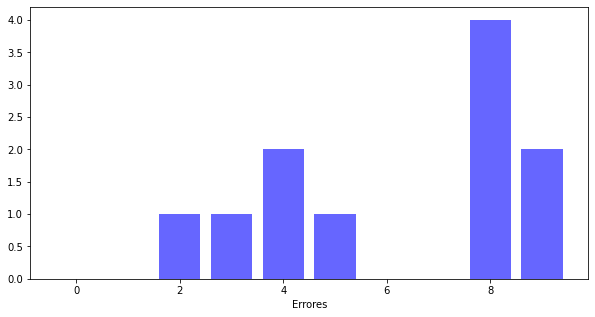

In [27]:
#Predicciones erroneas por digito
fig = plt.figure(figsize=(10, 5))
plt.bar(
    [0,1,2,3,4,5,6,7,8,9],
    Dsums,
    align='center',
    color="blue",
    alpha=0.6
)
plt.xlabel('Errores')
plt.show()

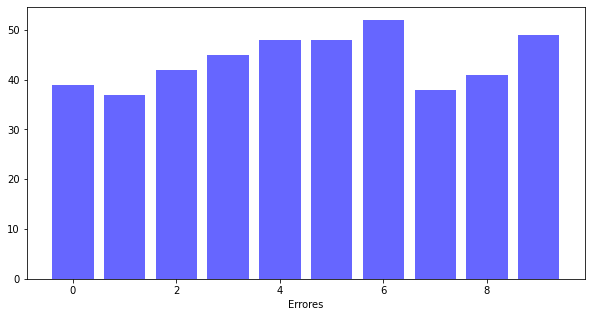

In [28]:
#Predicciones correctas por digito
fig = plt.figure(figsize=(10, 5))
plt.bar(
    [0,1,2,3,4,5,6,7,8,9],
    Isums,
    align='center',
    color="blue",
    alpha=0.6
)
plt.xlabel('Errores')
plt.show()

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Para empezar en un trabajo futuro habria que implementar de forma mas eficiente el KNN ya que incluso sin hacerlo me parece el mejor modelo, sobre todo cuando se reduce la dimensionalidad con tsne.
Respecto a los resultados vemos como efectivamente es comun confundir el digito "8" haciendolo pasar por otro digito en especial el "2".
Tambien no hay que dejase engañar por los pocos aciertos al identififcar el digito 7 ya que aunque es de los que tiene menos aciertos, no tiene errores por lo que esto debe ser causado por "mala suerte" al splitear el data set en test y training (muhcos "7" deben haber caido en training).

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [2]:
# read data
housing = pd.read_csv('https://raw.githubusercontent.com/GabrielVega1/mat281_portfolio_2022/master/homeworks/h2/housing.csv',sep=',')
housing.head()
df = housing
df.shape

(20640, 10)

In [3]:
#Vemos valores faltantes
df[df.isnull().any(axis=1)].shape

(207, 10)

Cantidad insignificante respecto al total (1%) asi que los borramos

In [4]:
df = df.dropna()
df.shape

(20433, 10)

In [5]:
#GetDummies a columna ocean_proximity
df_op = df[["ocean_proximity"]]
df_op = pd.get_dummies(df_op)
df = df.drop('ocean_proximity', axis=1)
df = pd.concat([df,df_op],axis=1)

# Split dataset (Parte 1)
Y = df.median_house_value
X = df.drop('median_house_value', axis=1)


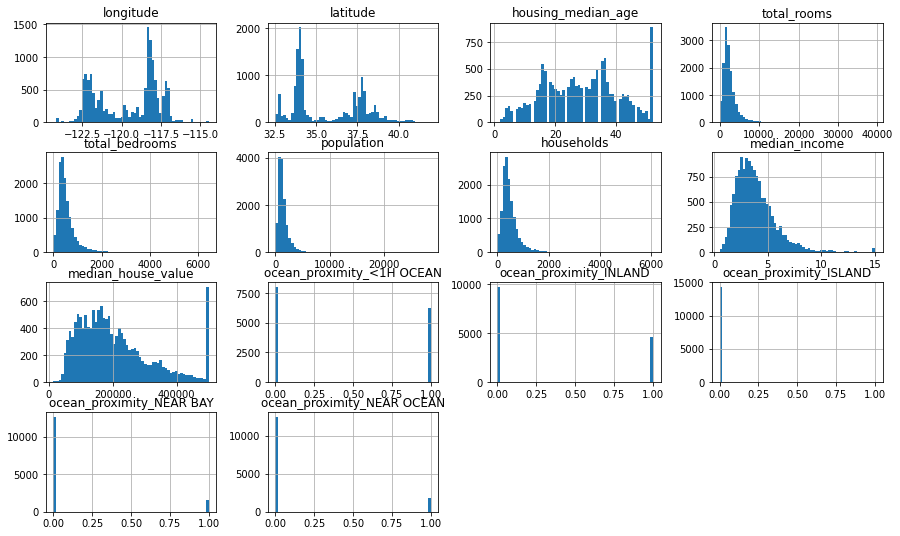

In [6]:
df_train,df_test = train_test_split(df,test_size=0.3,random_state=43)
df_train.hist(bins=60, figsize=(15,9))
plt.show()

<ipython-input-7-2ad154a41f48>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat,dtype=np.bool)


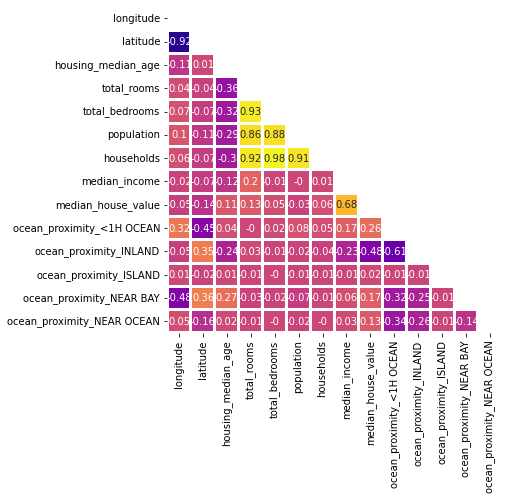

In [7]:
def corrMat(df,id=False):
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False)
    plt.show()  

corrMat(df_train)

In [8]:
#Normalizar X
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

Aqui podemos ver distintas relaciones como que rooms, bedrooms y population podrian reducirse a 1 parametro (ie eliminar 2 con SelectKBest)
Ahora usando primero reduccion de dimensionalidad con SelectKBest implementaremos una regresion logistica

In [13]:
def mape(y, yhat) -> float:
    metrica = np.mean(np.abs((y-yhat)/y))
    return metrica

In [ ]:
#SelectKBest
K = [6,7,8]
tiempos = []
accuaracys = [] 
for k in K:
  inicio = time.time()
  columnas = list(X.columns.values)
  seleccionadas = SelectKBest(f_classif, k=k).fit(X, Y)
  catrib = seleccionadas.get_support()
  atributos = [columnas[i] for i in list(catrib.nonzero()[0])]

  # Entrenamiento con las variables seleccionadas
  X_sk = X[atributos]
  Y_sk = Y
  
  X_train, X_test, Y_train, Y_test = train_test_split(X_sk, Y_sk, test_size=0.01, random_state=27)
  # Creando el modelo
  lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
  # Predecir
  Y_predict = lr.predict(X_test)
  print("Con ",k," variables metrica mape: ",mape(Y_test, Y_predict))
 


Resultados bastante decepcionantes por lo que intentaremos usar KNN con TSNE para predecir median_house_value

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


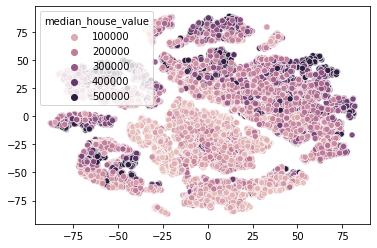

In [9]:
tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue = Y);
X_tsne = pd.DataFrame(X_tsne)

In [11]:
def KNN2(x,X_train, Y_train):
  #Añadimos el digito a identificar x al conjunto de datos para construir el modelo
  X_train = X_train.append(x, ignore_index=True)
  xpos = X_train.shape[0]-1
  #Creamos modelo vecinos mas cercanos
  model = NearestNeighbors(n_neighbors = 11)
  fit_model = model.fit(X_train)
  distance, indices = fit_model.kneighbors(X_train)
  #Obtenemos indices para los vecinos (11 vecinos) mas cercanos al desconocido digito x
  indices = list(indices[xpos])
  if(xpos in indices):
    indices.remove(xpos)
  return sum(np.array(Y_train.iloc[indices]))/10

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01, random_state=27)
Y_predict = []
for id in range(X_test.shape[0]):
  Y_predict.append(KNN2(X_test.iloc[id], X_train, Y_train))
Y_predict = np.array(Y_predict)

In [14]:
print("Metrica mape: ",mape(Y_test, Y_predict))

Metrica mape:  0.21481640144020173


Con un error del 20% ya es una mejora considerable (desde 100 a 20) pero aun es necesario, mejorar resultados asi.

Aqui por temas de tiempo no logre hacer otros modelos :(